In [2]:
import gymnasium as gym  # Updated from gym to gymnasium [1]
from gymnasium import spaces
from gymnasium.core import ActionWrapper, Wrapper
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import random
from itertools import count
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter  # Updated tensorboard import [1]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Defining the DDQN Model

In [3]:
class QNetwork(nn.Module):
    def __init__(self, actions):
        super().__init__()
        # Input layer matches 12D state space
        self.fc1 = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
        )  # Changed from 4 to 12

        # Dueling architecture branches
        self.value_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, actions)  # Keep action space size as in CartPole
        )

    def forward(self, state):
        x = F.relu(self.fc1(state))
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        return value + advantage - advantage.mean()

    def select_action(self, state):
        with torch.no_grad():
            q_values = self(state)  # Direct call instead of forward() [1]
            return torch.argmax(q_values).item()


class Memory(deque):  # Simplified memory implementation [1]
    def __init__(self, capacity):
        super().__init__(maxlen=capacity)

    def sample(self, batch_size):
        return random.sample(self, batch_size)


## Adding Custom No-Op Actions to the Environment

In [ ]:
class MultiNoOpWrapper(ActionWrapper):
    def __init__(self, env: gym.Env, n_noop: int, noop_action: int = 0):
        super().__init__(env)
        assert isinstance(env.action_space, spaces.Discrete), \
               "MultiNoOpWrapper only works for Discrete action spaces"

        self.orig_n     = env.action_space.n
        self.n_noop     = n_noop
        self.noop_action = noop_action

        # extend the action space
        self.action_space = spaces.Discrete(self.orig_n + self.n_noop)

    def action(self, action: int) -> int:
        # any new index ≥ orig_n becomes the no-op
        if action >= self.orig_n:
            return self.noop_action
        return action

In [5]:
# Updated environment creation [1]
env = gym.make("LunarLander-v3")
env = MultiNoOpWrapper(env, n_noop=20, noop_action=0)
n_state = env.observation_space.shape[0]

online_net = QNetwork(24).to(device)
target_net = QNetwork(24).to(device)
target_net.load_state_dict(online_net.state_dict())

optimizer = torch.optim.AdamW(online_net.parameters(), lr=1e-4)  # Modern optimizer [1]


## Training Loop

In [6]:
BATCH_SIZE = 64
NUM_EPISODES = 1000
UPDATE_INTERVAL = 4
GAMMA = 0.99
EPS_START = 0.5
EPS_END = 0.01
EPS_DECAY = (EPS_END/EPS_START)**(1.0/NUM_EPISODES*0.1)
learning_steps = 0


memory = Memory(50000)
writer = SummaryWriter('logs/ddqn/lunarlander')

In [7]:
epsilon = EPS_START
episode_reward = 0

for epoch in range(410):
    state, _ = env.reset()  # Updated reset unpacking [1]
    episode_reward = 0

    for t in count():
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action = online_net.select_action(state_tensor)

        # Updated step returns unpacking [1]
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        memory.append((state, next_state, action, reward, done))

        if len(memory) >= BATCH_SIZE:
            # Experience replay
            transitions = memory.sample(BATCH_SIZE)
            batch = list(zip(*transitions))
            learning_steps += 1

            # Update target network
            if learning_steps % UPDATE_INTERVAL == 0:
                target_net.load_state_dict(online_net.state_dict())

            states = torch.tensor(batch[0], dtype=torch.float32, device=device)
            next_states = torch.tensor(batch[1], dtype=torch.float32, device=device)
            actions = torch.tensor(batch[2], dtype=torch.long, device=device).unsqueeze(1)
            rewards = torch.tensor(batch[3], dtype=torch.float32, device=device).unsqueeze(1)
            dones = torch.tensor(batch[4], dtype=torch.float32, device=device).unsqueeze(1)

            # Double DQN update
            with torch.no_grad():
                next_actions = online_net(next_states).argmax(1, keepdim=True)
                target_q = target_net(next_states).gather(1, next_actions)
                target = rewards + (1 - dones) * GAMMA * target_q

            current_q = online_net(states).gather(1, actions)
            loss = F.mse_loss(current_q, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epsilon = max(epsilon * EPS_DECAY, EPS_END)


        if done:
            break
        state = next_state

    writer.add_scalar('episode_reward', episode_reward, epoch)

    if epoch % 10 == 0:
        torch.save(online_net.state_dict(), 'ddqn-policy-lunar.pt')  # Updated file extension [1]
        print(f'Epoch {epoch}: Reward {episode_reward:.2f}, epsilon {epsilon:.4f}')


<ipython-input-7-c46d06bf9c86>:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.tensor(batch[0], dtype=torch.float32, device=device)


Epoch 0: Reward -140.72, epsilon 0.4951
Epoch 10: Reward -142.84, epsilon 0.3595
Epoch 20: Reward -162.95, epsilon 0.2568
Epoch 30: Reward -175.26, epsilon 0.1332
Epoch 40: Reward -235.41, epsilon 0.0769
Epoch 50: Reward -154.95, epsilon 0.0451
Epoch 60: Reward -247.94, epsilon 0.0252
Epoch 70: Reward 211.76, epsilon 0.0124
Epoch 80: Reward -183.91, epsilon 0.0100
Epoch 90: Reward -96.49, epsilon 0.0100
Epoch 100: Reward -177.45, epsilon 0.0100
Epoch 110: Reward -93.82, epsilon 0.0100
Epoch 120: Reward -19.29, epsilon 0.0100
Epoch 130: Reward -1.89, epsilon 0.0100
Epoch 140: Reward -68.89, epsilon 0.0100
Epoch 150: Reward -44.05, epsilon 0.0100
Epoch 160: Reward -80.64, epsilon 0.0100
Epoch 170: Reward -20.21, epsilon 0.0100
Epoch 180: Reward -62.33, epsilon 0.0100
Epoch 190: Reward -17.36, epsilon 0.0100
Epoch 200: Reward 6.22, epsilon 0.0100
Epoch 210: Reward -21.94, epsilon 0.0100
Epoch 220: Reward -78.30, epsilon 0.0100
Epoch 230: Reward 21.59, epsilon 0.0100
Epoch 240: Reward -5.9

## Plotting functions

In [10]:
rewards_ddqn = np.convolve(rewards, np.ones(10)/10, mode='valid')

In [11]:
rewards_dqn = np.loadtxt("dqn_rewards_20_noop.txt")

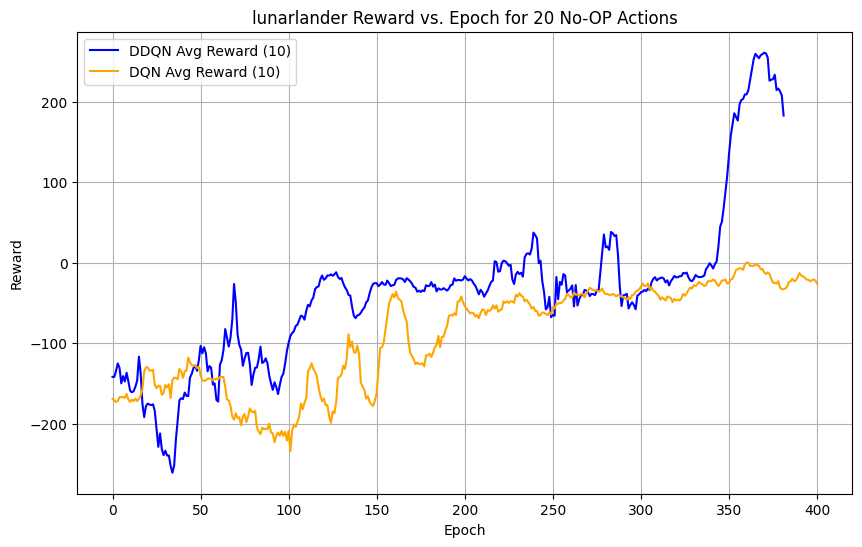

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards_ddqn)), rewards_ddqn, label='DDQN Avg Reward (10)', color='blue')
plt.plot(range(len(rewards_dqn)), rewards_dqn, label='DQN Avg Reward (10)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.title('lunarlander Reward vs. Epoch for 20 No-OP Actions')
plt.legend()
plt.grid()
plt.show()